In [13]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from PIL import Image, ImageEnhance

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import random

In [14]:
train_dir = 'brain-tumor-mri-dataset/Training/'
test_dir = 'brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

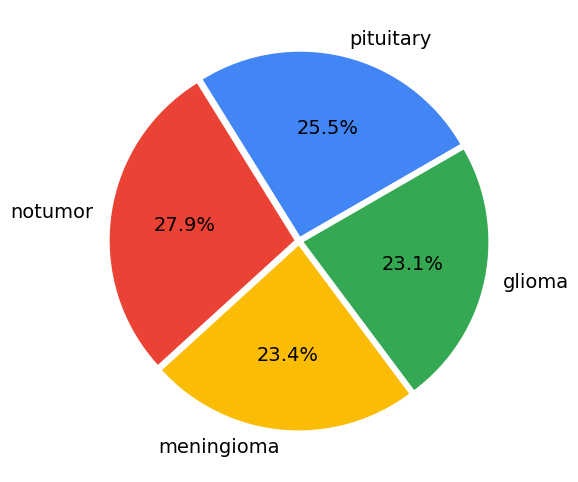

In [15]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [16]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

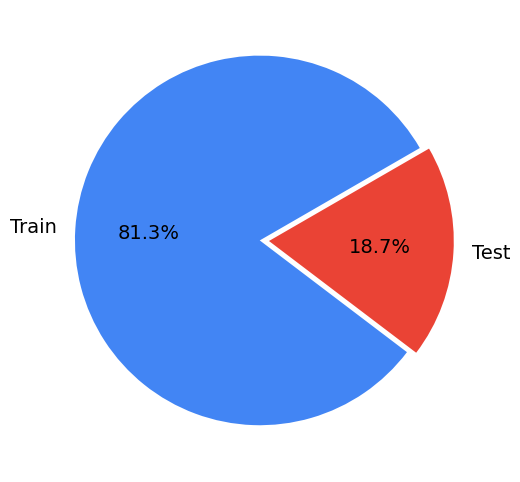

In [17]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [18]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    
    brightness_factor = random.uniform(0.8, 1.2)
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.8, 1.2)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    
    if random.random() < 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    if random.random() < 0.5:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    
    rotation_angle = random.uniform(-10, 10)  # in degrees
    image = image.rotate(rotation_angle)
    
    shear_factor = random.uniform(-0.2, 0.2)
    image = image.transform(image.size, Image.AFFINE, (1, shear_factor, 0, 0, 1, 0))
    
    crop_ratio = random.uniform(0.8, 1.0)
    image = ImageOps.crop(image, (image.width * (1 - crop_ratio)) // 2)
    
    if random.random() < 0.5:
        image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1)))

    image = np.array(image) / 255.0
    return image

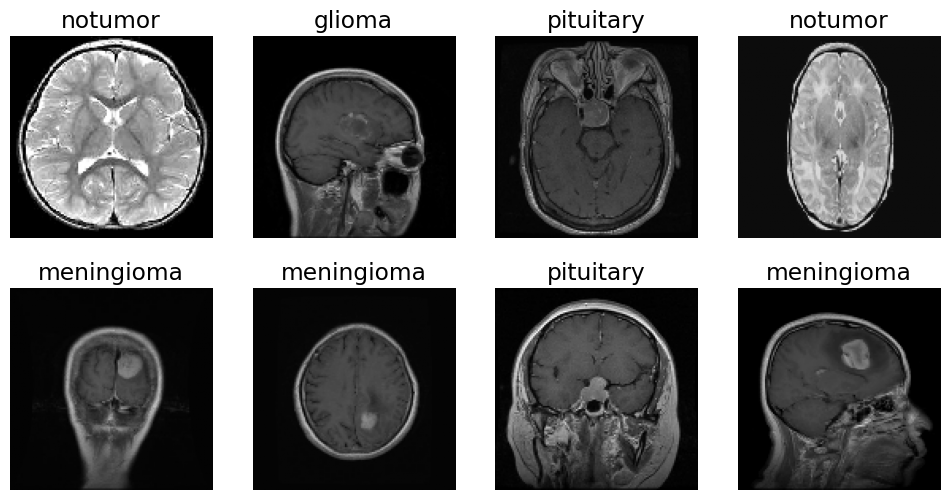

In [19]:
IMAGE_SIZE = 128

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [20]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [21]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 25
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epoczsyhs, steps_per_epoch=steps)

Epoch 1/25
178/178 [==============================] - 285s 2s/step - loss: 0.4661 - sparse_categorical_accuracy: 0.8225
Epoch 2/25
178/178 [==============================] - 281s 2s/step - loss: 0.2417 - sparse_categorical_accuracy: 0.9040
Epoch 3/25
178/178 [==============================] - 282s 2s/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9366
Epoch 4/25
178/178 [==============================] - 281s 2s/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9535
Epoch 5/25
178/178 [==============================] - 280s 2s/step - loss: 0.1046 - sparse_categorical_accuracy: 0.9629
Epoch 6/25
178/178 [==============================] - 284s 2s/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9685
Epoch 7/25
178/178 [==============================] - 286s 2s/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9857
Epoch 8/25
178/178 [==============================] - 284s 2s/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9903
Epoch 9/25
178/178 [====================

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
cm = confusion_matrix(test_labels,y_pred) 

In [ ]:
cm

In [ ]:
x_axis_labels = ['glioma','meningioma','notumor','pituitary'] 
y_axis_labels = ['glioma','meningioma','notumor','pituitary'] 

plt.figure()
sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True,fmt='d')
plt.yticks(rotation=0) 
plt.show()